In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, List, Tuple, Dict, Optional, Union

import qubx
%qubxd dev

%load_ext autoreload
%autoreload 2

from qubx.data.readers import (
    CsvStorageDataReader, AsPandasFrame, AsOhlcvSeries, AsQuotes, RestoreTicksFromOHLC, AsTimestampedRecords,
)

import qubx.pandaz.ta as pta
import numpy as np
import pandas as pd

from qubx.ta.indicators import (pewma, pewma_outliers_detector)


 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
r = CsvStorageDataReader('../tests/data/csv/')
ohlc = r.read('SOLUSDT', start='2024-04-01', stop='+15h', transform=AsOhlcvSeries('1Min', 'ms'))

ohlc_p = ohlc.pd()
qs = ohlc.close
ps = ohlc_p['close']


## PEWMA

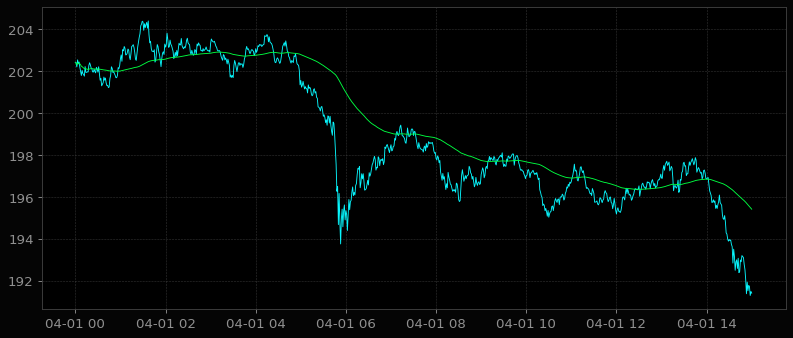

In [3]:
p0 = pta.pwma(ps, 0.99, 0.01, 30)
plt.plot(ps)
plt.plot(p0.Mean)


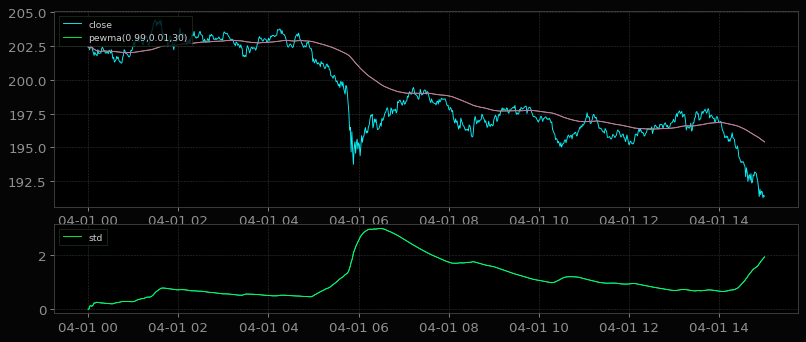

In [7]:
p1 = pewma(qs, 0.99, 0.01, 30)
sbp(31,1,r=2)
qs.plot()
p1.plot()
plt.plot(p0.Mean)
sbp(31,3)
plt.plot(p0.Std)
p1.std.plot()


In [16]:
# abs(np.mean(p1.pd() - p0.Mean)) < 1e-3
abs(np.mean(p1.std.pd() - p0.Std)) < 1e-3


True

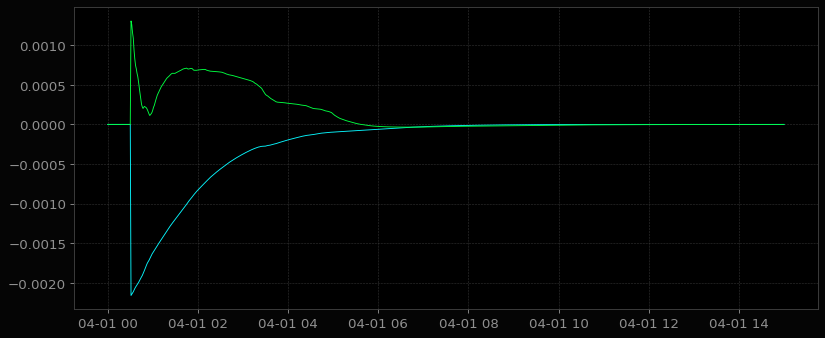

In [5]:
plt.plot(p1.pd() - p0.Mean)
plt.plot(p1.std.pd() - p0.Std)


## pwma_outliers_detector

In [3]:
t0 = pta.pwma_outliers_detector(ps, 0.99, 0.01)
t1 = pewma_outliers_detector(qs, 0.99, 0.01)


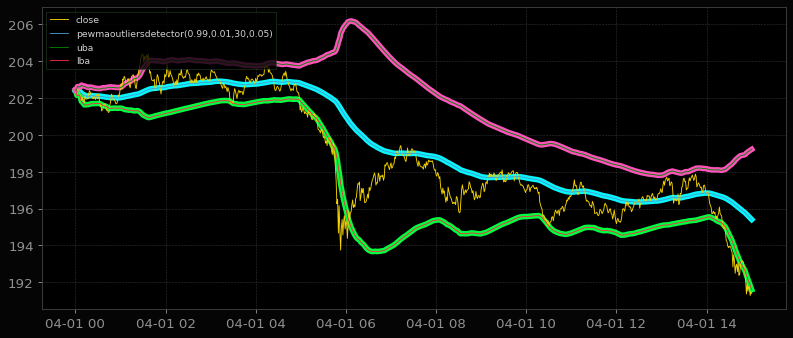

In [4]:
plt.plot(t0.m, lw=5)
plt.plot(t0.l, lw=5)
plt.plot(t0.u, lw=5)

qs.plot()
t1.plot()
t1.u.plot()
t1.l.plot()


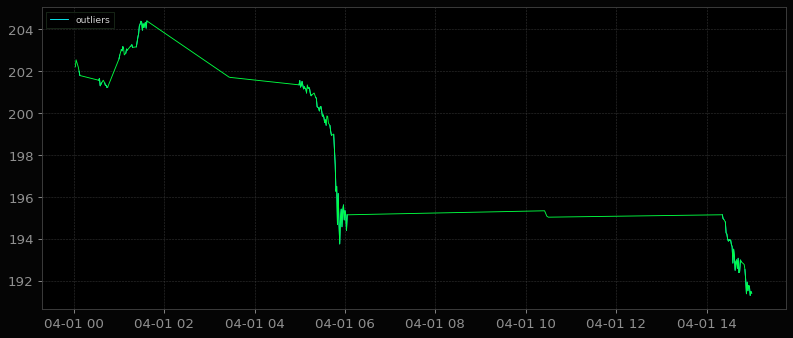

In [8]:
# plt.plot(t1.outliers)
t1.outliers.plot()
plt.plot(t0.outliers)


In [9]:
t1.outliers.pd().dropna()


2024-04-01 00:03:00    202.543
2024-04-01 00:07:00    201.998
2024-04-01 00:08:00    201.795
2024-04-01 00:33:00    201.569
2024-04-01 00:34:00    201.659
                        ...   
2024-04-01 14:56:00    191.770
2024-04-01 14:57:00    191.714
2024-04-01 14:58:00    191.285
2024-04-01 14:59:00    191.480
2024-04-01 15:00:00    191.396
Name: outliers, Length: 136, dtype: float64

In [10]:
t0.outliers


timestamp
2024-04-01 00:02:00    202.207
2024-04-01 00:03:00    202.543
2024-04-01 00:06:00    202.187
2024-04-01 00:07:00    201.998
2024-04-01 00:08:00    201.795
                        ...   
2024-04-01 14:56:00    191.770
2024-04-01 14:57:00    191.714
2024-04-01 14:58:00    191.285
2024-04-01 14:59:00    191.480
2024-04-01 15:00:00    191.396
Name: close, Length: 146, dtype: float64

In [ ]:
from qubx.core.series import TimeSeries; from qubx.ta.indicators import sma; del sys.modules['qubx.core.series']; del sys.modules['qubx.ta.indicators']
from qubx.core.series import TimeSeries, OHLCV, lag, compare
from qubx.core.utils import recognize_time
from qubx.ta.indicators import (norm_pdf, Pewma, pewma)
